In [1]:
# import
import tensorflow as tf
import numpy as np
from tensorflow import keras
import os
from PIL import Image
import shutil

# costants
SEED = 0xDED

target_w = 512
target_h = 512

batch_size = 4

use_crop = True

In [2]:
# intialization and common utilities

tf.random.set_seed(SEED)
np.random.seed(SEED)

def fromCwd(path):
    return os.path.join(os.getcwd(), path)


train_dir = fromCwd("training")
valid_dir = fromCwd("validation")
data_dir = fromCwd("data")
temp_dir = fromCwd("temp")

In [3]:
# crop image

# make crops and return the sub images
def cropImg(image, target_w, target_h):
    w, h = image.size
    div_x = int(w/target_w)
    div_y = int(w/target_h)
    if div_x <= 0:
        div_x = 1
    if div_y <= 0:   
        div_y = 1
    

    w /= div_x
    h /= div_y

    sub_images = []
    # x and y are swapped to have array "rows" match image rows
    for y in range(div_y):
        for x in range(div_y):
            sz = (x*w, y*h, x*w + w, y*h + h)
            sub_images.append(image.crop(sz))

    return sub_images

#save images to disk
def saveImagesArray(images, original_name, dest_dir):
    filename, file_extension = os.path.splitext(original_name)
    for i in range(len(images)):
        img = images[i]
        w, h = img.size
        img.save(os.path.join(dest_dir, filename + "_cp" + str(i) + "_" + str(w) + "x" + str(h) + "." + file_extension))

# recursively crop all images into a directory maitaining the same
# internal structure to the destination
def cropAllTo(source_dir, dest_dir, target_w, target_h):
    if(os.path.exists(dest_dir)):
        print("[Skipped] Directory already exists: "+ dest_dir)
        return
    else:
        os.mkdir(dest_dir)

    # iterate all files and check if directory or not
    for fl in os.listdir(source_dir): # return relative paths
        if os.path.isdir(os.path.join(source_dir, fl)):
            # start again with the new source as the dir path
            cropAllTo(os.path.join(source_dir, fl), os.path.join(dest_dir, fl), target_w, target_h) 
        else:
            im = Image.open(os.path.join(source_dir, fl))
            # here we got an image and se shold split it and save
            images = cropImg(im, target_w, target_h)
            saveImagesArray(images, fl, dest_dir)
    print("Generated " + dest_dir)


# move all data to images or mask folders into dest dir
def moveRecursive(source_dir, folders, percent):

    items = os.listdir(source_dir)
    print("Moving from "+ source_dir)

    if not "Images" in items: # normal top folder we should explore all its sub folders
        for fold in items:
            moveRecursive(os.path.join(source_dir, fold), folders, percent)
        return # no more to do in this folder

    # here we got Images in subfolder
    im_dir = os.path.join(source_dir, "Images")
    ms_dir = os.path.join(source_dir, "Masks")
    # read all images and masks
    images = os.listdir(im_dir)
    masks = os.listdir(ms_dir)

    # make validation
    for i in range(int(len(images) * percent)):
        idx = np.random.randint(0, len(images))

        # move both image and mask to validation folder
        os.rename(os.path.join(im_dir, images[idx]), os.path.join(folders[2], images[idx]))
        os.rename(os.path.join(ms_dir, masks[idx]), os.path.join(folders[3], masks[idx]))

        # update refreshed folders without moved elements
        images = os.listdir(im_dir)
        masks = os.listdir(ms_dir)

    # create train set
    for img in images:
        os.rename(os.path.join(im_dir, img), os.path.join(folders[0], img))
    for msk in masks:
        os.rename(os.path.join(ms_dir, msk), os.path.join(folders[1], msk))

    


# move all data from subfolders in source folder to Images/Mask folders in dest folder
def prepareTrainData(source_dir, train_dir, valid_dir, percent = 0.1):

    folders = [] # order: Test_img | Test_mask | valid_img | valid_mask
    for parent in [train_dir, valid_dir]:
        for sub in ["Images", "Masks"]:
            folders.append(os.path.join(parent,sub))

    # check if a folder already exist and skip 
    for f in folders:
        if os.path.exists(f):
            print("[Skipped] Directory already exists: "+ f)
            return folders

    # create folders
    for f in folders:   
        os.makedirs(f)

    moveRecursive(source_dir, folders, percent)
    print("Train and Valid set ready")

    return folders


if use_crop:
    cropAllTo(data_dir, temp_dir, target_w, target_h)  
else:
    if not os.path.exists(temp_dir):
        shutil.copytree(data_dir, temp_dir) # required to copy everythin because preparaTrainData move images

folders = prepareTrainData(temp_dir, train_dir, valid_dir)

Generated f:\Develop\scassorflow\homework-2\temp\Bipbip\Haricot\Images
Generated f:\Develop\scassorflow\homework-2\temp\Bipbip\Haricot\Masks
Generated f:\Develop\scassorflow\homework-2\temp\Bipbip\Haricot
Generated f:\Develop\scassorflow\homework-2\temp\Bipbip\Mais\Images
Generated f:\Develop\scassorflow\homework-2\temp\Bipbip\Mais\Masks
Generated f:\Develop\scassorflow\homework-2\temp\Bipbip\Mais
Generated f:\Develop\scassorflow\homework-2\temp\Bipbip
Generated f:\Develop\scassorflow\homework-2\temp\Pead\Haricot\Images
Generated f:\Develop\scassorflow\homework-2\temp\Pead\Haricot\Masks
Generated f:\Develop\scassorflow\homework-2\temp\Pead\Haricot
Generated f:\Develop\scassorflow\homework-2\temp\Pead\Mais\Images
Generated f:\Develop\scassorflow\homework-2\temp\Pead\Mais\Masks
Generated f:\Develop\scassorflow\homework-2\temp\Pead\Mais
Generated f:\Develop\scassorflow\homework-2\temp\Pead
Generated f:\Develop\scassorflow\homework-2\temp\Roseau\Haricot\Images
Generated f:\Develop\scassorf

In [4]:
import matplotlib.pyplot as plt

%matplotlib inline

def printGrid(sub_im):
    plt.figure(figsize=(27, 27))
    for i in range(len(sub_im)):
        ax = plt.subplot(IMG_DIVIDER, IMG_DIVIDER ,i+1)
        
        plt.imshow(np.uint8(sub_im[i]))
        plt.axis("off")
        
    plt.plot()


#printGrid(sub_images)
    

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# create generators
rot_range = 45
h_shift = 10
w_shift = 10
h_flip = True
w_flip = True
zoom = 0.3

img_data_gen = ImageDataGenerator(
    rotation_range=rot_range,
    width_shift_range=w_shift,
    height_shift_range=h_shift,
    zoom_range=zoom,
    horizontal_flip=h_flip,
    vertical_flip=w_flip,
    fill_mode='reflect'
    )

mask_data_gen = ImageDataGenerator(
    rotation_range=rot_range,
    width_shift_range=w_shift,
    height_shift_range=h_shift,
    zoom_range=zoom,
    horizontal_flip=h_flip,
    vertical_flip=w_flip,
    fill_mode='reflect'
    )


In [6]:
  #convert a mask in rgb to actual classes
  def rgb_to_class(mask_arr):

    new_mask_arr = np.zeros(mask_arr.shape[:2], dtype=mask_arr.dtype)

    # Use RGB dictionary in 'RGBtoTarget.txt' to convert RGB to target
    new_mask_arr[np.where(np.all(mask_arr == [216, 124, 18], axis=-1))] = 0
    new_mask_arr[np.where(np.all(mask_arr == [255, 255, 255], axis=-1))] = 1
    new_mask_arr[np.where(np.all(mask_arr == [216, 67, 82], axis=-1))] = 2

    return new_mask_arr

In [7]:
#create custom generator

class CustomGenerator(tf.keras.utils.Sequence):

  def __init__(self, directory, img_generator=None, mask_generator=None, preprocessing_function=None, out_shape=[256, 256]):
    self.img_generator = img_generator
    self.mask_generator = mask_generator
    self.preprocessing_function = preprocessing_function
    self.out_shape = out_shape
    self.im_path = os.path.join(directory, "Images")
    self.ms_path = os.path.join(directory, "Masks")
    self.images = np.sort(os.listdir(self.im_path)) 
    self.masks = np.sort(os.listdir(self.ms_path)) 


  def __len__(self):
    return len(self.images)


  def __getitem__(self, index):
    # Read Image
    img = Image.open(os.path.join(self.im_path, self.images[index]))
    mask = Image.open(os.path.join(self.ms_path, self.masks[index]))

    # Resize image and mask
    img = img.resize(self.out_shape)
    mask = mask.resize(self.out_shape, resample=Image.NEAREST)
    
    img_arr = np.array(img)
    mask_arr = np.array(mask)

    out_mask = []

    if self.img_generator is not None and self.mask_generator is not None:
        # Perform data augmentation
        img_t = self.img_generator.get_random_transform(img_arr.shape, seed=SEED)
        mask_t = self.mask_generator.get_random_transform(mask_arr.shape, seed=SEED)
        img_arr = self.img_generator.apply_transform(img_arr, img_t)
        # ImageDataGenerator use bilinear interpolation for augmenting the images.
        # Thus, when applied to the masks it will output 'interpolated classes', which
        # is an unwanted behaviour. As a trick, we can transform each class mask 
        # separately and then we can cast to integer values (as in the binary segmentation notebook).
        # Finally, we merge the augmented binary masks to obtain the final segmentation mask.
        out_mask = np.zeros_like(mask_arr)
        for c in np.unique(mask_arr):
          if c > 0:
            curr_class_arr = np.float32(mask_arr == c)
            curr_class_arr = self.mask_generator.apply_transform(curr_class_arr, mask_t)
            # from [0, 1] to {0, 1}
            curr_class_arr = np.uint8(curr_class_arr)
            # recover original class
            curr_class_arr = curr_class_arr * c 
            out_mask += curr_class_arr
    else:
      out_mask = mask_arr
    
    if self.preprocessing_function is not None:
        img_arr = self.preprocessing_function(img_arr)

    out_mask = rgb_to_class(np.float32(out_mask))
    out_mask = np.expand_dims(out_mask, -1)


    return img_arr, out_mask

In [8]:
train = CustomGenerator(train_dir,
                        img_generator=img_data_gen, 
                        mask_generator=mask_data_gen,
                        out_shape=[target_w, target_h]
                        )

valid = CustomGenerator(valid_dir, out_shape=[target_w, target_h])

print("Train dataset size: "+ str(len(train)))
print("Validation dataset size: " + str(len(valid)))


Train dataset size: 564
Validation dataset size: 60


In [9]:
out_pt = (tf.float32, tf.float32)
out_shp = ([target_h, target_w, 3], [target_h, target_w, 1])

train_dataset = tf.data.Dataset.from_generator(lambda: train, output_types=out_pt, output_shapes=out_shp).batch(batch_size).repeat()

valid_dataset = tf.data.Dataset.from_generator(lambda: valid, output_types=out_pt, output_shapes=out_shp).batch(batch_size).repeat()

print(train_dataset)


<RepeatDataset shapes: ((None, 512, 512, 3), (None, 512, 512, 1)), types: (tf.float32, tf.float32)>


In [10]:
import time
from matplotlib import cm
import matplotlib.pyplot as plt

%matplotlib inline

# Assign a color to each class
evenly_spaced_interval = np.linspace(0, 1, 20)
colors = [cm.rainbow(x) for x in evenly_spaced_interval]

iterator = iter(train_dataset)




[0. 1. 2.]


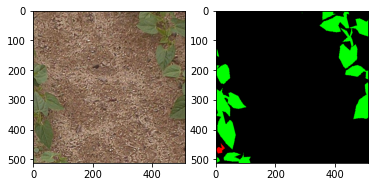

[0. 1.]


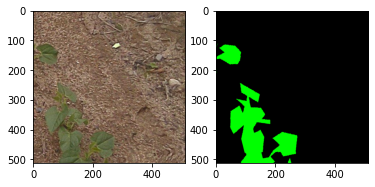

In [23]:
for k in range(2):
  # plot
  fig, ax = plt.subplots(1, 2)

  augmented_img, target = next(iterator)
  augmented_img = augmented_img[0]   # First element
  augmented_img = augmented_img  # denormalize


  target = np.array(target[0, ..., 0])   # First element (squeezing channel dimension)

  print(np.unique(target))

  target_img = np.zeros([target.shape[0], target.shape[1], 3])

  target_img[np.where(target == 0)] = [0, 0, 0]
  target_img[np.where(target == 1)] = [0, 255, 0] 
  target_img[np.where(target == 2)] = [255, 0, 0] 

  ax[0].imshow(np.uint8(augmented_img))
  ax[1].imshow(np.uint8(target_img))

  plt.show()